### Read a netcdf formated smi par file and plot on a world map

this notebook reads and maps par in standard mapped image format

https://oceancolor.gsfc.nasa.gov/docs/technical/ocean_level-3_smi_products.pdf

In [13]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from e582utils.data_read import download
import warnings
warnings.filterwarnings("ignore")
import pyproj
from e582lib.map_slices import  make_basemap_xy
from rasterio.transform import from_bounds

l3file='A2007008.L3m_DAY_PAR_par_9km.nc'
download(l3file)

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/A2007008.L3m_DAY_PAR_par_9km.nc
writing to: A2007008.L3m_DAY_PAR_par_9km.nc

A2007008.L3m_DAY_PAR_par_9km.nc already exists
and is 14345758 bytes
will not overwrite



#### Extract the variables and the _FillValue and replace missing data with np.nan

See http://unidata.github.io/netcdf4-python/

In [2]:
with Dataset(l3file,'r') as ncdat:
    ncdat.set_auto_mask(False)
    par=ncdat.variables['par'][...]
    lat=ncdat.variables['lat'][...]
    lon=ncdat.variables['lon'][...]
    fill_value=ncdat.variables['par']._FillValue
hit= par == fill_value
par[hit] = np.nan

#### set up the palette

In [3]:
cmap=matplotlib.cm.YlGn_r  #see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps
cmap.set_over('r')
cmap.set_under('0.85')
cmap.set_bad('0.75') #75% grey
vmin= 0
vmax= 100
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)

#### plot using https://nsidc.org/data/atlas/epsg_4326.html

/Users/phil/mini35/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py


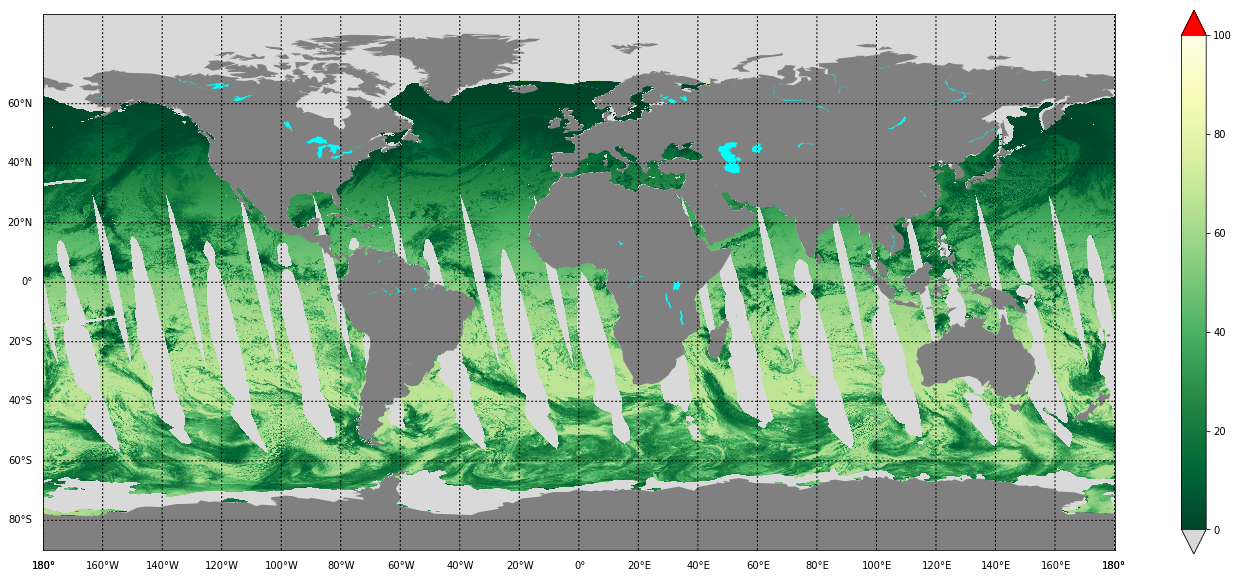

In [4]:
%matplotlib inline
import mpl_toolkits
print(mpl_toolkits.basemap.__file__)
bmap=Basemap(ellps='WGS84',projection='cyl')
lonvals,latvals = np.meshgrid(lon,lat)
fig, ax = plt.subplots(1,1,figsize=(24,20))
xvals,yvals=bmap(lonvals,latvals)
cs=bmap.pcolormesh(xvals,yvals,par,cmap=cmap,norm=the_norm)
cs=bmap.imshow(par,cmap=cmap,norm=the_norm,origin='upper')
bmap.fillcontinents(color='grey',lake_color='cyan');
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')
parallels=np.arange(-80, 80, 20)
meridians=np.arange(-180, 180, 20)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);

### write a function that returns slices to extract a lon/lat box

In [ ]:
def find_box(lon,lat,ll_lat,ll_lon,ur_lat,ur_lon):
    """
    Given 1-d arrays of longitude and latitude, find slices that
    would return all values within a 2-d lat and lon box bounded
    by lower left and ur right corners
    
    Parameters
    ----------
    
    lon: 1-d ndarray of longitudes (smallest to larges)
    
    lat: 1-d ndarray of latitudes (most positive to most negative)
    
    ll_lat,ll_lon: float
       lower left latitude and longitude, in degrees
       
    ur_lat,ur_lon: float
        upper right latitude and logitude, in degrees
        
    Returns
    -------
    
    row_slice, col_slice: python slice objects
        slices to use to subset the image
    
    """
    lon_index=np.searchsorted(lon,ur_lon)
    lat_index=np.searchsorted(lat[::-1],ur_lat)
    lat_index=len(lat) - lat_index
    ur_lat_index=lat_index
    ur_lon_index=lon_index
    lon_index=np.searchsorted(lon,ll_lon)
    lat_index=np.searchsorted(lat[::-1],ll_lat)
    lat_index=len(lat) - lat_index
    ll_lat_index=lat_index
    ll_lon_index=lon_index
    row_slice=slice(ur_lat_index,ll_lat_index)
    col_slice=slice(ll_lon_index,ur_lon_index)
    return row_slice,col_slice

### Pick a box in the Pacific NW and set up the math

In [5]:
ur_lat=50
ur_lon=-120
ll_lat=40
ll_lon=-130

row_slice,col_slice=find_box(lon,lat,ll_lat,ll_lon,ur_lat,ur_lon)
lat_slice=latvals[row_slice,col_slice]
lon_slice=lonvals[row_slice,col_slice]
basemap_args=dict(llcrnrlat=lat_slice[-1,0],llcrnrlon=lon_slice[-1,0],
                 urcrnrlat=lat_slice[0,-1],urcrnrlon=lon_slice[0,-1],ellps='WGS84',
                 projection='cyl')

### Plot the box to make sure we're getting the geolocation right

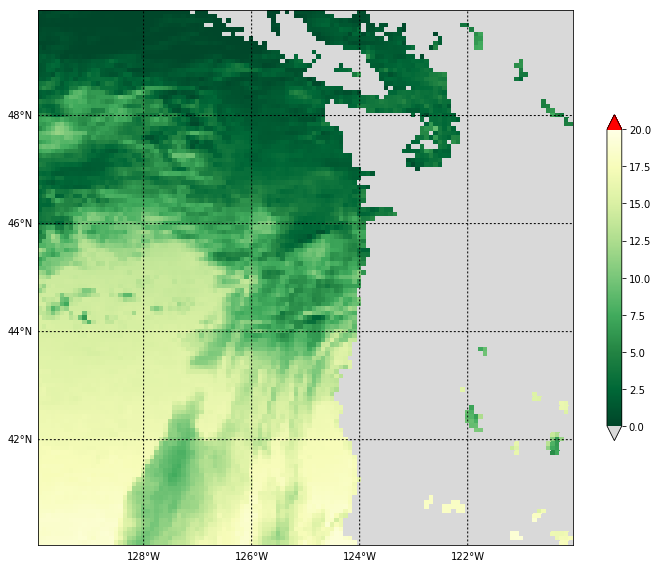

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
basemap_args.update(dict(resolution='i',ax=ax))
bmap = Basemap(**basemap_args)
xvals, yvals=bmap(lon_slice,lat_slice)
par_slice=par[row_slice,col_slice]
vmin= 0
vmax= 20
the_norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax,clip=False)
cs=bmap.pcolormesh(xvals,yvals,par_slice,cmap=cmap,norm=the_norm)
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')
parallels=np.arange(40, 60, 2)
meridians=np.arange(-130, -120,2)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);

### note that basemap returns x,y in degrees

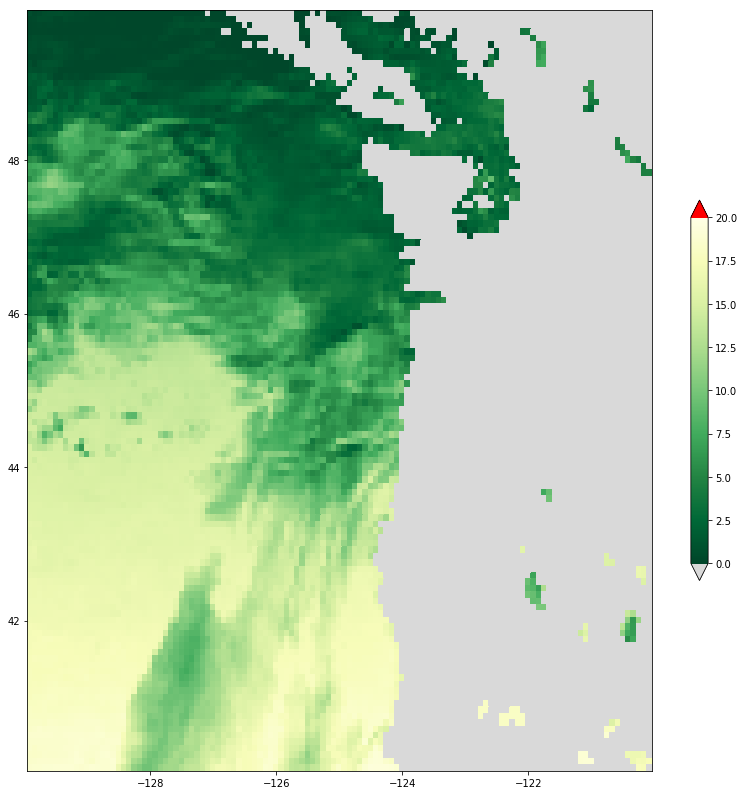

In [7]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
cs=ax.pcolormesh(xvals,yvals,par_slice,cmap=cmap,norm=the_norm)
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')

### Now repeat, using pyproj with the eqc projection

In [8]:
src_crs=dict(units='m',proj='eqc',datum='WGS84')
src_proj=pyproj.Proj(src_crs)

### note the units are meters

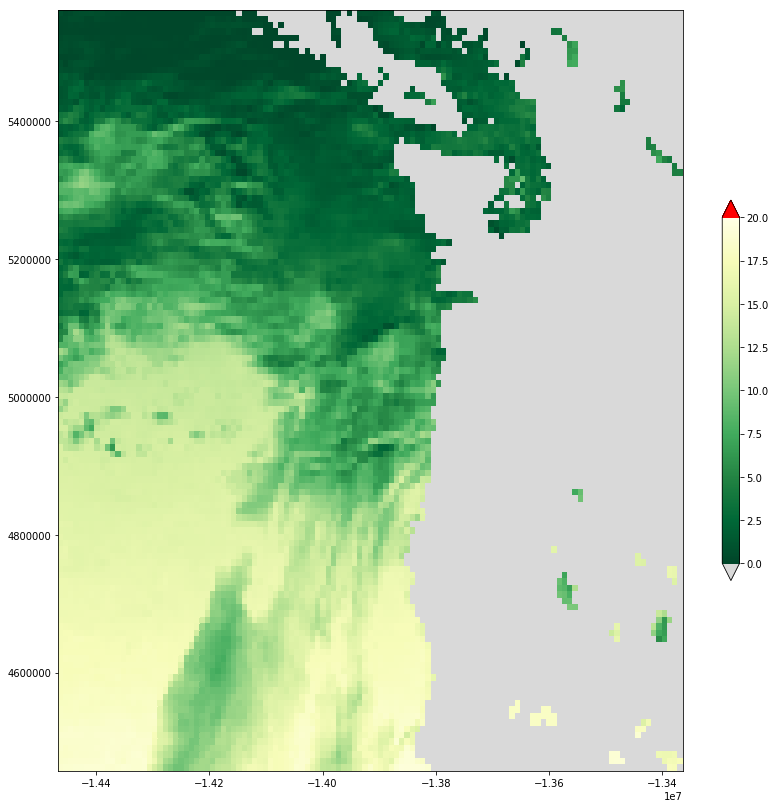

In [9]:
p_xvals,p_yvals=src_proj(lon_slice,lat_slice)
fig, ax = plt.subplots(1,1,figsize=(14,14))
cs=ax.pcolormesh(p_xvals,p_yvals,par_slice,cmap=cmap,norm=the_norm)
colorbar=fig.colorbar(cs, shrink=0.5, pad=0.05,extend='both')

### Reproject using pyresample


So now -- do a reprojection from pyproj eqc to pyproj laea  -- keep the lon,lat of the map
corners the same in the new projection and the same number of pixels in the destination raster

In [10]:
from pyresample import image, geometry

llcrnrlat=lat_slice[-1,0]
llcrnrlon=lon_slice[-1,0]
urcrnrlat=lat_slice[0,-1]
urcrnrlon=lon_slice[0,-1]
llcrnrx,llcrnry=src_proj(llcrnrlon,llcrnrlat)
urcrnrx,urcrnry=src_proj(urcrnrlon,urcrnrlat)
src_extent=[llcrnrx,llcrnry,urcrnrx,urcrnry]
src_height,src_width = par_slice.shape

from_def = geometry.AreaDefinition('src', 'src image', 'area_src',
                               src_crs,
                               src_width, src_height,
                               src_extent)

lat_0=(lat_slice[0,0]+lat_slice[-1,0])/2.
lon_0=(lon_slice[0,0]+lon_slice[0,-1])/2.
dst_crs={'datum': 'WGS84','lat_0': lat_0,'lon_0': lon_0,'proj': 'laea'}
dst_proj=pyproj.Proj(dst_crs)
llcrnrx,llcrnry=dst_proj(llcrnrlon,llcrnrlat)
urcrnrx,urcrnry=dst_proj(urcrnrlon,urcrnrlat)
dst_extent=[llcrnrx,llcrnry,urcrnrx,urcrnry]
to_def = geometry.AreaDefinition('big', 'big image','area_big',
                               dst_crs,
                               src_width,src_height,
                               dst_extent)

from_nn = image.ImageContainerNearest(par_slice,from_def, radius_of_influence=50000)
to_nn = from_nn.resample(to_def)
result_data_nn = to_nn.image_data
dst_extent

[-423196.25058119465,
 -538011.7993638769,
 355874.52924180217,
 562164.3373083986]

### plot the reprojected image as a raw bitmap

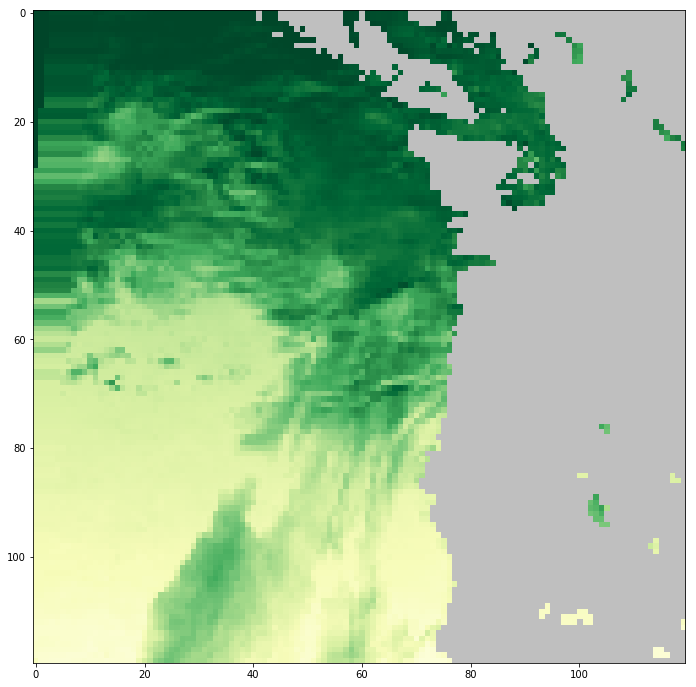

In [11]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.imshow(result_data_nn,cmap=cmap,norm=the_norm,origin='upper');

### Put the coastline on the map

{'a': 6378137.0,
 'b': 6356752.314245179,
 'lat_0': 44.99999809265137,
 'lon_0': -124.99999618530273,
 'proj': 'laea',
 'units': 'm',
 'x_0': 423196.25055538694,
 'y_0': 538011.799360027}

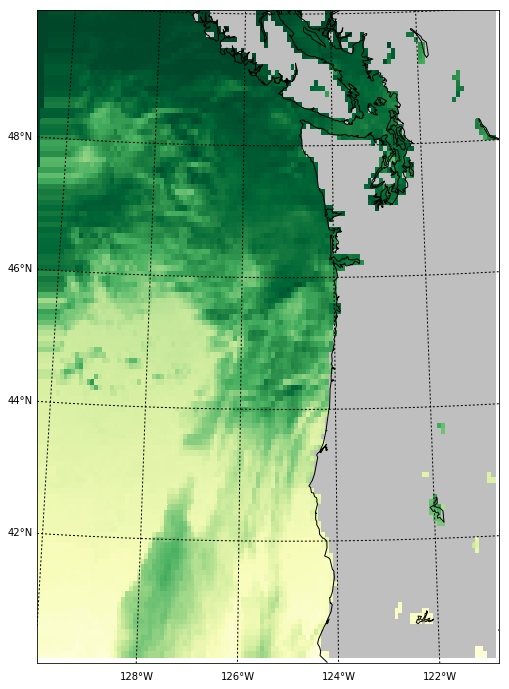

In [15]:
ll_dict=dict(llcrnrlat=llcrnrlat,llcrnrlon=llcrnrlon,urcrnrlat=urcrnrlat,
                  urcrnrlon=urcrnrlon)
basemap_args={k:dst_crs[k] for k in ['lat_0','lon_0']}
basemap_args['projection'] = 'laea'
basemap_args['ellps']='WGS84'
basemap_args.update(ll_dict)
fig,ax = plt.subplots(1,1,figsize=(12,12))
basemap_args['ax']=ax
basemap_args['resolution']='i'
bmap=Basemap(**basemap_args)
height,width=result_data_nn.shape
transform = from_bounds(llcrnrx, llcrnry, urcrnrx, urcrnry, width, height)
xvals,yvals=make_basemap_xy(0,height,0,width,bmap,transform)
#bmap.imshow(result_data_nn,cmap=cmap,norm=the_norm,origin='upper')
result_masked=np.ma.masked_invalid(result_data_nn)
bmap.pcolormesh(xvals,yvals,result_masked,cmap=cmap,norm=the_norm)
bmap.drawcoastlines();
parallels=np.arange(40, 60, 2)
meridians=np.arange(-130, -120,2)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],\
                  fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],\
                  fontsize=10, latmax=90);


### unlike epsg:4326 -- basemap and pyproj agree on the details of this projection

In [16]:
bmap.projparams

{'a': 6378137.0,
 'b': 6356752.314245179,
 'lat_0': 44.99999809265137,
 'lon_0': -124.99999618530273,
 'proj': 'laea',
 'units': 'm',
 'x_0': 423196.25055538694,
 'y_0': 538011.799360027}

In [18]:
test=pyproj.Proj(bmap.projparams)

In [19]:
test.srs

'+lat_0=44.99999809265137 +x_0=423196.25055538694 +b=6356752.314245179 +proj=laea +lon_0=-124.99999618530273 +y_0=538011.799360027 +a=6378137.0 +units=m '